<a id='top'></a>
# MLB Catcher Framerates

#### This is a walkthrough of how I calculated MLB catcher framerates and performed statistical analysis on the framerates.

#### If you want to skip to my math, [CLICK HERE](#math)

#### If you want to skip to my findings, [CLICK HERE](#findings)

#### If you want to download any .csv's I created, [CLICK HERE](#downloads)

In [1]:
# --- Imports --- #
# creating .db file
import savantscraper 
import sqlite3
# data cleaning
import pandas as pd
import numpy as np
# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import pylab
# import config
%matplotlib inline
pd.options.mode.chained_assignment = None

## Data Pulling:
<p>To start, we'll pull all <span style="background-color: #ffffff;">Statcast</span> data&nbsp;provided by&nbsp;MLB from 2008 through 2018.</p>
<ul>
<li>Statcast was introduced into the MLB in 2008 and records data on every single pitch thrown</li>
<li>We'll use the savantscraper module to webscrape&nbsp;<a href="https://baseballsavant.mlb.com/">https://baseballsavant.mlb.com</a>&nbsp;and write to a .db file</li>
<li>Information on each stat tracked in the .db file can be found here&nbsp;<a href="https://baseballsavant.mlb.com/csv-docs">https://baseballsavant.mlb.com/csv-docs</a></li>
</ul>

In [ ]:
# creating the .db file
allTeams = ['LAA', 'HOU', 'OAK', 'TOR', 'ATL', 'MIL', 'STL', 'CHC', 'ARI', 
            'LAD', 'SF', 'CLE', 'SEA', 'MIA', 'NYM', 'WSH', 'BAL', 'SD', 'PHI', 'PIT', 
            'TEX', 'TB', 'BOS', 'CIN', 'COL', 'KC', 'DET', 'MIN', 'CWS', 'NYY']
savantscraper.database_import('baseball_savant', (2008,2019), teams=allTeams)

<p>Before we can clean the data, we need turn the baseball_savant.db file into a pandas dataframe. Let's execute a SQL query to check how much data we have in this database.</p>

In [2]:
conn = sqlite3.connect('master_statcast.db') # connect to database
conn.text_factory = str                      # prevent an error decoding to utf8
pd.read_sql_query("select count(*) from statcast;", conn) # see how many rows we have

,count(*)
0,7846538


<p>Python doesn't have enough available memory to store a dataframe of 7846538 rows ( x 90 columns ). Let's only grab the columns needed to calculate framerate and then split our query up into a year by year basis so we can write a .csv for each year of statcast data.</p>

In [3]:
for year in range (2008,2019):
   df = pd.concat([x for x in pd.read_sql_query("select game_date, game_type, description, fielder_2, zone, pitch_type from statcast where game_date like '{}%';".format(year), conn, chunksize = 1000)])
   df.to_csv('framerateDFs/framerateDF{}.csv'.format(year), index=False) # creating the .csv for each year

<p>We can preview the 2018 dataframe to see what our .csv files look like.</p>

In [4]:
df.head(5)

,game_date,game_type,description,fielder_2,zone,pitch_type
0,2018-09-30,R,hit_into_play,460269.0,8.0,CH
1,2018-09-30,R,foul,460269.0,6.0,FF
2,2018-09-30,R,called_strike,460269.0,13.0,FF
3,2018-09-30,R,swinging_strike,460269.0,12.0,FF
4,2018-09-30,R,foul,460269.0,4.0,FF


<p>Next we need to create one big dataframe with our catcher data. A quick peek at any .csv from 2014 or earlier will reveal that there are NaN values for the <em>fielder_2</em> column.</p>

In [5]:
with open('framerateDFs/framerateDF2014.csv') as fin:
    yearPitchDF = pd.read_csv(fin)
yearPitchDF.head(5)

,game_date,game_type,description,fielder_2,zone,pitch_type
0,2014-09-28,R,hit_into_play,NaN,5.0,FF
1,2014-09-28,R,ball,NaN,11.0,FF
2,2014-09-28,R,hit_into_play_score,NaN,2.0,FF
3,2014-09-28,R,called_strike,NaN,14.0,SL
4,2014-09-28,R,ball,NaN,11.0,FF


<p>Turns out MLB didn't record who the catcher was on every pitch until 2015 on.</p>

<p>Since there's no catcher data before 2015, our dataframe will only include statcast pitches thrown in 2015 through 2018. Let's create our big dataframe.</p>

In [6]:
for year in range(2015,2019):
    with open('framerateDFs/framerateDF{}.csv'.format(year)) as fin:
        yearPitchDF = pd.read_csv(fin) # creating a temporary dataframe for each year
        if year == 2015:
            pitchDF = yearPitchDF # initializing the dataframe
        else:
            pitchDF = pd.concat([pitchDF, yearPitchDF]) # appending to the dataframe

<p>Let's preview our dataframe, view its shape, and count how many unique catchers there are.</p>

In [7]:
print(pitchDF.sort_values(by='game_date').head(3),end='\n\n')
print(pitchDF.sort_values(by='game_date').tail(3))
print('\nshape: {} x {}'.format(pitchDF.shape[0],pitchDF.shape[1]))
print('\n# of unique catchers: {}'.format(len(list(pitchDF.fielder_2.unique()))))

         game_date game_type    description  fielder_2  zone pitch_type
595696  2015-04-05         R  hit_into_play   425877.0  12.0         FC
310887  2015-04-05         R  called_strike   471083.0   5.0         FF
310886  2015-04-05         R           foul   471083.0   6.0         FF

         game_date game_type      description  fielder_2  zone pitch_type
680260  2018-10-28         W  swinging_strike   543877.0   4.0         SL
680282  2018-10-28         W  swinging_strike        NaN   NaN        NaN
680259  2018-10-28         W  swinging_strike   543877.0  13.0         CH

shape: 2902546 x 6

# of unique catchers: 171


<p>Now that we have a .csv for each year from 2008 to 2019, we can begin cleaning our data.<p/>

## Data Cleaning:

<p>To clean our data we need to remove:</p>
<ul>
<li>any NaN values</li>
<li>exhibition and spring training games</li>
<li>any pitches not called by the ump (i.e. the ball was hit into play, swinging strike, HBP, etc.)</li>
</ul>
<p>I also go ahead and create my <em>calledPitches</em> variable. We don't need it yet, but it will come in handy later</p>

In [8]:
pitchDF = pitchDF.dropna() # remove NaN values
pitchDF = pitchDF[(pitchDF.game_type != 'E') & (pitchDF.game_type != 'S')] # remove exhibition and spring training games
pitchDF = pitchDF[(pitchDF.description == 'ball') | (pitchDF.description == 'called_strike')] # keep pitches called by the ump
calledPitches = pitchDF.shape[0]

<p>Let's look at our cleaned up dataframe to ensure that:</p>
<ul>
<li>We&nbsp;only have regular season and postseason games from 2015 through 2018</li>
<li>We only include pitches called by the ump</li>
<li>We have no NaN values</li>
</ul>

In [9]:
print(pitchDF.sort_values(by='game_date').head(3),end='\n\n')
print(pitchDF.sort_values(by='game_date').tail(3))
print('\nshape: {} x {}'.format(pitchDF.shape[0],pitchDF.shape[1]))
print('\n# of unique catchers: {}'.format(len(list(pitchDF.fielder_2.unique()))))

         game_date game_type    description  fielder_2  zone pitch_type
595622  2015-04-05         R           ball   425877.0  13.0         FF
595715  2015-04-05         R  called_strike   425877.0   3.0         FC
595714  2015-04-05         R           ball   425877.0  13.0         CU

        game_date game_type    description  fielder_2  zone pitch_type
98728  2018-10-28         W           ball   605131.0  13.0         FF
98798  2018-10-28         W  called_strike   605131.0   4.0         SL
98713  2018-10-28         W           ball   605131.0  11.0         FF

shape: 1449381 x 6

# of unique catchers: 170


<p>Looks like we removed one catcher from the dataset in the process of cleaning the data.</p>

<p>We now have our completed pitchDF. This clean dataframe has all the information needed to perform analysis on the data later in this notebook.

<a id='math'></a>
## Calculating Runs Above Average and Added Calls per Game by Catcher

#### To view a short explanation of what perGame and RAA are before we calculate them, [CLICK HERE](#RAA)

<p>&nbsp;</p>
<p>Lets start by creating a list of every unique catcher mlb_id in our pitchDF.</p>

In [10]:
catcherList = [int(x) for x in list(pitchDF.fielder_2.unique())] # list of ints for each unique catcher id in our pitchDF
print(catcherList[:5])

[518700, 543302, 435559, 519237, 434563]


<p>Next we need to get every catcher's name. This is done using the player names and ID's .csv found at <a href="http://crunchtimebaseball.com/baseball_map.html">http://crunchtimebaseball.com/baseball_map.html</a></p>

NOTE: the .csv from crunchtime baseball is missing an entry for A.J. Pierzynski and will cause the script to error later on. I had to manually go in and add A.J.'s info into the .csv. My updated playerIDxref.csv can be downloaded here.

In [11]:
with open ('playerIDxref.csv','r') as fin:
    nameDF = pd.read_csv(fin)    # converting the xref csv into a dataframe
nameDF.head(2)

,mlb_id,mlb_name,mlb_pos,mlb_team,mlb_team_long,bats,throws,birth_year,bp_id,bref_id,...,retro_name,debut,yahoo_id,yahoo_name,ottoneu_id,ottoneu_name,ottoneu_pos,rotowire_id,rotowire_name,rotowire_pos
0,592091,A.J. Achter,P,LAA,Los Angeles Angels,R,R,1988.0,66919.0,achteaj01,...,A.J. Achter,20140903.0,9824.0,A.J. Achter,18093.0,A.J. Achter,RP,NaN,NaN,NaN
1,595918,A.J. Cole,P,CLE,Cleveland Indians,R,R,1992.0,68086.0,coleaj01,...,A.J. Cole,20150428.0,9638.0,A.J. Cole,14940.0,A.J. Cole,RP,11446.0,A.J. Cole,P


<p>Now let's create a dictionary that contains a dictionary for every catcher in our catcherList. In each catcher's dictionary we need 4 values:</p>
<ol style="list-style-type: lower-roman;">
<li>catcher name</li>
<li># of games caught in</li>
<li># of true balls caught</li>
<li># of wrong strikes caught</li>
</ol>
<p>For this dataset, I'm defining a true ball (tBall) as a pitch that the statcast deemed a ball. A wrong strike (wStrike) is a tBall that was called a strike by the umpire. The complete pitch call matrix can be viewed below</p>

![callMatrix](callMatrix1.png)

In [12]:
catcherDict = {}
for catcher in catcherList:
    name = nameDF[nameDF['mlb_id'] == catcher].iloc[0,1] # getting catcher name from the xref df
    gamesCaught = pitchDF[pitchDF['fielder_2'] == catcher].game_date.unique().shape[0] # total number of games caught in
    tBall = pitchDF[(pitchDF.zone > 10) & (pitchDF.fielder_2 == catcher)] 
    wStrike = tBall[tBall['description'] == 'called_strike'] 
    catcherDict[catcher] = {'name': name, 'gamesCaught':gamesCaught, 'tBall':tBall.shape[0], 'wStrike':wStrike.shape[0]}

<p>Lets preview our catcher dictionary by looking at Brian McCann.</p>

In [13]:
catcherDict[435263]

{'name': 'Brian McCann', 'gamesCaught': 397, 'tBall': 18241, 'wStrike': 1592}

<p>Next we'll turn our catcher dictionaries into one big dataframe to track stats by catcher.</p>

In [14]:
catcherFR = pd.DataFrame.from_dict(catcherDict, orient='index') # df with all catcher rates since 2015
catcherFR.head(2)

,name,gamesCaught,tBall,wStrike
150229,A.J. Pierzynski,171,7929,688
408042,Gerald Laird,1,30,2


<p>Now we can begin to crunch numbers for each catcher.  

To start, let's count the stolen pitch rate (sRate) for each catcher.</p>

\begin{align*}
sRate = \frac{wStrike}{tBall}
\end{align*}

In [15]:
catcherFR['sRate'] = catcherFR.apply(lambda row: row.wStrike / row.tBall, axis=1) # applies the function accross every row 
catcherFR.head(2)

,name,gamesCaught,tBall,wStrike,sRate
150229,A.J. Pierzynski,171,7929,688,0.086770
408042,Gerald Laird,1,30,2,0.066667


<p>Now we need to calculate each catcher's blown pitch rate (<em>bRate</em>)</p>
\begin{align*}
bRate = \frac{wBall}{tStrike}
\end{align*}
<p>In order to calculate bRate we first need to create the <em>tStrike</em> and <em>wBall</em> columns in our dataframe</p>

In [16]:
catcherFR['tStrike'] = 0
catcherFR['wBall'] = 0
catcherFR.head(2)

,name,gamesCaught,tBall,wStrike,sRate,tStrike,wBall
150229,A.J. Pierzynski,171,7929,688,0.086770,0,0
408042,Gerald Laird,1,30,2,0.066667,0,0


<p>Next, let's update each catcher's&nbsp;<em>tStrike&nbsp;</em>and&nbsp;<em>wBall</em> in the datframe.</p>

In [17]:
for catcher in catcherDict:
    catcherFR.loc[catcherFR.index == catcher, 'tStrike'] = pitchDF[(pitchDF.zone < 10) & (pitchDF.fielder_2 == catcher)].shape[0] 
    catcherFR.loc[catcherFR.index == catcher, 'wBall'] = pitchDF[(pitchDF.zone < 10) & (pitchDF.fielder_2 == catcher) & (pitchDF.description == 'ball')].shape[0]
catcherFR.head(2)

,name,gamesCaught,tBall,wStrike,sRate,tStrike,wBall
150229,A.J. Pierzynski,171,7929,688,0.086770,3916,743
408042,Gerald Laird,1,30,2,0.066667,9,3


<p>Let's appened each catcher's <em>bRate</em> to the dataframe.</p>

In [18]:
catcherFR = catcherFR[catcherFR['tStrike'] != 0] # remove any catcher who hasn't caught a strike to avoid division by 0 error
catcherFR['bRate'] = catcherFR.apply(lambda row: row.wBall / row.tStrike, axis=1)
catcherFR.head(2)

,name,gamesCaught,tBall,wStrike,sRate,tStrike,wBall,bRate
150229,A.J. Pierzynski,171,7929,688,0.086770,3916,743,0.189734
408042,Gerald Laird,1,30,2,0.066667,9,3,0.333333


<p>Our dataframe currently includes catchers who only caught one game. Let's filter out all catchers with less than 50 games played.</p>

In [19]:
print('# of Catchers: {}'.format(catcherFR.shape[0]))
catcherFR = catcherFR[catcherFR['gamesCaught'] >= 50] # only include catchers with at least 50 games caught in
print('# of Catchers with > 50 games caught: {}'.format(catcherFR.shape[0]))

# of Catchers: 169
# of Catchers with > 50 games caught: 100


<p>Next we need to calculate league average rates for <em>sRate</em> and for <em>bRate</em>. Even though it's repetitive, lets append the league averages to each row of our dataframe so we can perform row operations for our remaining calculations.</p>

In [20]:
catcherFR['leagueSR'] = catcherFR.loc[:,['sRate']].describe().iloc[1,0] # grabbing the mean of the sRate column
catcherFR['leagueBR'] = catcherFR.loc[:,['bRate']].describe().iloc[1,0] # grabbing the mean of the bRate column
catcherFR.head(2)

,name,gamesCaught,tBall,wStrike,sRate,tStrike,wBall,bRate,leagueSR,leagueBR
150229,A.J. Pierzynski,171,7929,688,0.08677,3916,743,0.189734,0.082945,0.151302
424325,David Ross,128,5050,505,0.10000,2338,323,0.138152,0.082945,0.151302


<p>Now we can calculate the difference between each catcher's <em>sRate</em> and <em>leagueSR</em>, as well as the difference between <em>bRate</em> and <em>leagueBR</em>.</p>

\begin{align*}
srDiff = sRate - leagueSR
\end{align*}
\begin{align*}
brDiff = bRate - leagueBR
\end{align*}


In [21]:
catcherFR['srDiff'] = catcherFR.apply(lambda row: row.sRate - row.leagueSR, axis=1)
catcherFR['brDiff'] = catcherFR.apply(lambda row: row.bRate - row.leagueBR, axis=1)
catcherFR.head(2)

,name,gamesCaught,tBall,wStrike,sRate,tStrike,wBall,bRate,leagueSR,leagueBR,srDiff,brDiff
150229,A.J. Pierzynski,171,7929,688,0.08677,3916,743,0.189734,0.082945,0.151302,0.003825,0.038433
424325,David Ross,128,5050,505,0.10000,2338,323,0.138152,0.082945,0.151302,0.017055,-0.013150


<p>By multiplying a catcher's <em>srDiff</em> by <em>tBall</em> we can calculate the number of extra strikes that catcher received in comparison to the expected number of called strikes for a league 'average' catcher. The same math can be applied to <em>brDiff</em> and <em>tStrike</em> to calculate the number of extra balls a catcher received in comparison to the expected number of called balls for a league 'average' catcher.</p>

\begin{align*}
extraStr = srDiff * tBall
\end{align*}
\begin{align*}
extraBall = brDiff * tStrike
\end{align*}


In [22]:
catcherFR['extraStr'] = catcherFR.apply(lambda row: row.srDiff * row.tBall, axis=1)
catcherFR['extraBall'] = catcherFR.apply(lambda row: row.brDiff * row.tStrike, axis=1)
catcherFR.loc[:,['name','tBall','extraStr','tStrike','extraBall']].head(2)

,name,tBall,extraStr,tStrike,extraBall
150229,A.J. Pierzynski,7929,30.327250,3916,150.502106
424325,David Ross,5050,86.126575,2338,-30.743635


<p>Just to reiterate what <em>extraStr</em> and <em>extraBall</em> are, David Ross caught 5050 true balls. Of those 5050 true balls, David Ross got 86 more strike calls than a catcher who has an <em>sRate</em> equal to the average <em>sRate</em> for all catchers in the league would have gotten.</p>

<p>Now we can calculate the difference between <em>extraStr</em> and <em>extraBall</em> to get a <em>netExtra</em>, that is, the number of additional strikes a catcher has gotten compared to if a league 'average' catcher had been behind the plate.</p>

\begin{align*}
netExtra = extraStr - extraBall
\end{align*}

In [23]:
catcherFR['netExtra'] = catcherFR.apply(lambda row: row.extraStr - row.extraBall, axis=1)
catcherFR.loc[:,['name','extraStr','extraBall','netExtra']].head(2)

,name,extraStr,extraBall,netExtra
150229,A.J. Pierzynski,30.327250,150.502106,-120.174857
424325,David Ross,86.126575,-30.743635,116.870210


<p>Lets calculate the total number of pitches each catcher has caught and then divide our <em>netExtra</em> by the total number of pitches caught to come up with <em>extraRate</em>, the rate at which each catcher gets a strike call that the league 'average' catcher would not have gotten. It is implied that a catcher with a negative <em>netExtra</em> loses more calls than the league 'average' catcher would.</p>

\begin{align*}
extraRate = \frac{netExtra}{pitchTotal}
\end{align*}


In [24]:
catcherFR['pitchTotal'] = catcherFR.apply(lambda row: row.tBall + row.tStrike, axis=1)
catcherFR['extraRate'] = catcherFR.apply(lambda row: row.netExtra / row.pitchTotal, axis=1)
catcherFR.loc[:,['name','pitchTotal','extraRate']].head(2)

,name,pitchTotal,extraRate
150229,A.J. Pierzynski,11845,-0.010146
424325,David Ross,7388,0.015819


<p>Finally, we can multiply <em>extraRate</em> by the average number of called pitches a catcher catches each game to find out their <em>perGame</em> rates. Before we can do that though, we need to calculate the average number of called pitches a catcher catches each game. Remember the start of this notebook where I said we would need the calledPitches variable? Well now lets put it to use.</p>

In [25]:
totalGames = (2430 * 4) + (36 + 35 + 38 + 33) # hard coded the number of postseason games for each season
calledPerGame = int(calledPitches / totalGames / 2) # total called in a game split since each catchers catches half on average
calledPerGame

73

<p>It's worth noting that my calculated value of 73 called pitches per game is lower than the average called per game value that statcorner uses in their calculations (they use 78, but I couldn't find where they got that number from). This discrepency may be due to the fact that I filtered out any rows with a NaN value from the original pitchDF before I counted <em>calledPitches</em>. This discrepency won't impact the rankings or variance of the data, but might result in a lower mean <em>RAA</em> and <em>perGame</em> value than statcorner calculates.</p>

<p>Finally, lets multiply <em>extraRate</em> with <em>calledPerGame</em> to crunch our <em>perGame</em> value for each catcher.We can also multiply each catcher's <em>perGame</em> rate with their total games caught to calculate each catcher's <em>RAA</em> from 2015 through 2018. More information on what RAA is and where it is flawed is available in the data analysis section.</p>

\begin{align*}
perGame = extraRate * calledPerGame
\end{align*}
\begin{align*}
RAA = perGame * gamesCaught
\end{align*}


In [26]:
catcherFR['perGame'] = catcherFR.apply(lambda row: row.extraRate * calledPerGame, axis=1)
catcherFR['RAA'] = catcherFR.apply(lambda row: row.gamesCaught * row.perGame * 0.133, axis=1)
catcherFR.loc[:,['name','perGame','RAA']].head(2)

,name,perGame,RAA
150229,A.J. Pierzynski,-0.740630,-16.844152
424325,David Ross,1.154781,19.658999


<p>Now that we have our final dataframe populated with data, lets pretty it up. We need to sort the dataframe by <em>RAA</em>, add rankings to each catcher and name their <em>mlb_id</em> column.</p>

In [27]:
catcherFR = catcherFR.loc[:,['name','perGame','RAA']].sort_values(by='RAA', ascending=False)
catcherFR = catcherFR.reset_index()
catcherFR = catcherFR.rename(columns={"index": "mlb_id"})
catcherFR.index += 1

<p>Let's view our final dataframe</p>

In [28]:
catcherFR

,mlb_id,name,perGame,RAA
1,518735,Yasmani Grandal,1.563085,103.945129
2,452095,Tyler Flowers,1.693622,79.288605
3,457763,Buster Posey,1.331269,73.833497
4,455117,Martin Maldonado,1.061045,57.012069
5,595978,Austin Hedges,1.288708,43.020932
6,425877,Yadier Molina,0.574160,40.701652
7,425772,Jeff Mathis,1.555466,39.720388
8,465041,Francisco Cervelli,0.752091,39.210997
9,488771,Jason Castro,0.821298,37.794488
10,518595,Travis d'Arnaud,1.125489,36.973441


<p>Finally, lets write our finished catcher framerate dataframe to a .csv that is easily read back into a df for statistical analysis.</p>

In [29]:
catcherFR.to_csv('catcherFR.csv', index=False)

<p>Lets also write the catchFR dataframe to a second .csv but sorted by perGame to use later in data analysis</p>

In [30]:
catcherFRpg = catcherFR.sort_values(by='perGame', ascending=False)
catcherFRpg = catcherFRpg.reset_index()
catcherFRpg.index += 1
catcherFRpg = catcherFRpg.drop('index',axis=1)
catcherFRpg.to_csv('catcherFRpg.csv',index=False)

## Calculating Call Rates By Pitch Type

<p>This section takes the same math and logic used to calculate <em>extraRate</em> for catchers and applies it to each pitch type. This is simply to view which pitches (if any) have the best call rates. More information on the practical application of call rates by pitch type can be found in the statistical analysis section</p>

<p>To start we need to get a list of every unique pitch in our pitchDF</p>

In [31]:
pitchTypes = [x for x in list(pitchDF.pitch_type.unique())]
print('head: {}\ntail: {}'.format(pitchTypes[:5],pitchTypes[-5:]))

head: ['FF', 'CH', 'CU', 'SL', 'FT']
tail: ['160421_182411', '160421_182300', '160421_182242', '160421_182222', 'UN']


Information on Statcast pitch type and abbreviations can be found at https://library.fangraphs.com/pitch-type-abbreviations-classifications/

If you take a look at the pitchTypes list, you'll notice some pitch types are numbered values that don't have documentation. Because of this we will only count pitch types that do have MLB Statcast documentation

In [32]:
cleanPTypes = [x for x in pitchTypes if len(x) == 2] # pitches that have documentation
print(cleanPTypes)

['FF', 'CH', 'CU', 'SL', 'FT', 'SI', 'FS', 'FC', 'KC', 'EP', 'FA', 'SC', 'KN', 'FO', 'UN']


<p>Now we have a list of pitch_type codes, but it's not very human readable. Lets create an xref to use that maps pitch_type to a human readable pitch name</p>

In [33]:
pitchXref = {'FF':'4-seam','FT':'2-seam','CH':'changeup','CU':'curveball','SL':'slider','SI':'sinker',
            'FS':'split-fast','FC':'cutter','KC':'knuckle-curve','EP':'eephus','FA':'pitch-out',
            'SC':'screwball','KN':'knuckleball','FO':'fastball-out','UN':'unknown'}

<p>Now lets create a dictionary of dictionaries with each catcher's framerate per pitch type. This step combines the code used for catchers to grab all four types of pitches from our pitch call matrix</p>

In [34]:
pitchRDict = {}
for pitch in cleanPTypes:
    name = pitchXref[pitch]
    pitchTBall = pitchDF[(pitchDF.zone > 10) & (pitchDF.pitch_type == pitch)] # statcast saw a ball
    pitchWStrike = pitchTBall[pitchTBall['description'] == 'called_strike'] # statcast saw a ball, ump called a strike
    pitchTStrike = pitchDF[(pitchDF.zone < 10) & (pitchDF.pitch_type == pitch)] # statcast saw a strike
    pitchWBall = pitchTStrike[pitchTStrike['description'] == 'ball'] # statcast saw a strike, ump called a ball
    pitchRDict[name] = {'tBall':pitchTBall.shape[0],'wStrike':pitchWStrike.shape[0],'tStrike':pitchTStrike.shape[0],'wBall':pitchWBall.shape[0]}

<p>Lets create our dataframe to track stats by pitch type.</p>

In [35]:
pitchFR = pd.DataFrame.from_dict(pitchRDict, orient='index')
pitchFR.head(2)

,tBall,wStrike,tStrike,wBall
2-seam,118920,11521,58608,8772
4-seam,353283,33583,183481,27936


<p>Now that we have a dataframe we can begin all our row operations to crunch <em>extraRate</em>. Rather than step through each step of code like I did in the catchers section, I'll execute it all at once and we can view the final dataframe.</p>

In [36]:
pitchFR['sRate'] = pitchFR.apply(lambda row: row.wStrike / row.tBall, axis=1)
pitchFR['bRate'] = pitchFR.apply(lambda row: row.wBall / row.tStrike, axis=1)
pitchFR['totalCalled'] = pitchFR.apply(lambda row: row.tBall + row.tStrike, axis=1)
pitchFR = pitchFR[pitchFR['totalCalled'] > 500]
pitchFR['leagueSR'] = pitchFR.loc[:,['sRate','bRate']].describe().iloc[1,0]
pitchFR['leagueBR'] = pitchFR.loc[:,['sRate','bRate']].describe().iloc[1,1]
pitchFR['srDiff'] = pitchFR.apply(lambda row: row.sRate - row.leagueSR, axis=1)
pitchFR['brDiff'] = pitchFR.apply(lambda row: row.bRate - row.leagueBR, axis=1)
pitchFR['extraStr'] = pitchFR.apply(lambda row: row.srDiff * row.tBall, axis=1)
pitchFR['extraBall'] = pitchFR.apply(lambda row: row.brDiff * row.tStrike, axis=1)
pitchFR['extraDiff'] = pitchFR.apply(lambda row: row.extraStr - row.extraBall, axis=1)
pitchFR['extraRate'] = pitchFR.apply(lambda row: row.extraDiff / row.totalCalled, axis=1)
pitchFR['extraRate']

2-seam           0.015245
4-seam           0.013018
changeup        -0.017822
curveball        0.004257
cutter           0.005329
knuckle-curve    0.005333
knuckleball     -0.015803
sinker           0.020314
slider          -0.000221
split-fast      -0.029140
Name: extraRate, dtype: float64

<p>Finally I'll write the complete dataframe to a .csv for easily reloading the data and output it below.</p>

In [37]:
pitchFR.to_csv('pitchFR.csv', index=True)
pitchFR

,tBall,wStrike,tStrike,wBall,sRate,bRate,totalCalled,leagueSR,leagueBR,srDiff,brDiff,extraStr,extraBall,extraDiff,extraRate
2-seam,118920,11521,58608,8772,0.096880,0.149672,177528.0,0.077529,0.156586,0.019351,-0.006913,2301.211369,-405.175076,2706.386445,0.015245
4-seam,353283,33583,183481,27936,0.095060,0.152256,536764.0,0.077529,0.156586,0.017530,-0.004330,6193.203608,-794.501980,6987.705588,0.013018
changeup,101096,5820,29019,4845,0.057569,0.166960,130115.0,0.077529,0.156586,-0.019960,0.010374,-2017.905747,301.039388,-2318.945135,-0.017822
curveball,80507,5781,44636,5996,0.071807,0.134331,125143.0,0.077529,0.156586,-0.005722,-0.022255,-460.654249,-993.359587,532.705338,0.004257
cutter,51060,4293,21829,3364,0.084078,0.154107,72889.0,0.077529,0.156586,0.006548,-0.002479,334.352106,-54.109383,388.461490,0.005329
knuckle-curve,23656,1729,14401,1947,0.073089,0.135199,38057.0,0.077529,0.156586,-0.004440,-0.021387,-105.033971,-307.990757,202.956785,0.005333
knuckleball,3850,296,1831,374,0.076883,0.204260,5681.0,0.077529,0.156586,-0.000646,0.047674,-2.487943,87.291572,-89.779515,-0.015803
sinker,84967,8596,47599,6769,0.101169,0.142209,132566.0,0.077529,0.156586,0.023639,-0.014377,2008.564912,-684.323035,2692.887947,0.020314
slider,144508,10238,67284,9617,0.070847,0.142931,211792.0,0.077529,0.156586,-0.006682,-0.013654,-965.609279,-918.712664,-46.896616,-0.000221
split-fast,14193,680,3784,696,0.047911,0.183932,17977.0,0.077529,0.156586,-0.029618,0.027347,-420.373865,103.479687,-523.853552,-0.029140


<a id='findings'></a>
# Findings


Before I really dig into this data, it's worth noting that there ARE flaws in this data and lots of unknowns; umpire call rate ([check this out for a fun read into umpire call bias](http://www.bu.edu/articles/2019/mlb-umpires-strike-zone-accuracy)), pitch location, and pitch type all impact perGame and RAA. This notebook and data are <em>not</em> intended to make conclusive findings, but rather start a discussion about the art of framing, what impacts it, and who's the best at it.

<a id='RAA'></a>
## RAA and perGame Catcher Analysis

<p>Runs Above Average (RAA) is a rough estimate of the total added value in runs a team has gained (or lost) from playing a catcher. It is calculated by multiplying Added Calls per Game (perGame) times 0.133 times the total number of games the catcher has caught in.</p>
<p>&nbsp;</p>
\begin{align*}
RAA = perGame * gamesCaught * 0.133
\end{align*}
<p>&nbsp;</p>

0.133 is a VERY rough estimate of how much run value is generated by an above average frame and [was calculated by Dan Turkenkopf back in 2008.](https://www.beyondtheboxscore.com/2008/5/12/506919/a-nibble-here-a-nibble-the) perGame is the number of pitches each game that a catcher gets above the 'average' mlb catcher. For example, Austin Hedges ~ 1.3 perGame means that he on average nets 1.3 more strikes per game than the 'average' mlb catcher would (framing a ball the 'average' catcher woudn't get OR not losing a strike that the 'average' catcher would lose). For a more in-depth breakdown of the process I used to calculate perGame, check out [this example using only 2012 catcher data.](http://www.statcorner.com/exp_PreliminaryCatchingFramework.php)

#### To return to the math section, [CLICK HERE](#math)

<p>Lets start by reading our df from the the framerateByCatcherDF.csv we created earlier and looking at the top 5 catchers based on RAA.</p>

In [38]:
catcherFR = pd.read_csv('catcherFR.csv')
catcherFR.index += 1 # offset python base 0 index
catcherFR.head(5)

,mlb_id,name,perGame,RAA
1,518735,Yasmani Grandal,1.563085,103.945129
2,452095,Tyler Flowers,1.693622,79.288605
3,457763,Buster Posey,1.331269,73.833497
4,455117,Martin Maldonado,1.061045,57.012069
5,595978,Austin Hedges,1.288708,43.020932


<p>We should always common sense check our data. Are these really the top 5 framing catchers from 2015 through 2018?</p>
<ul>
<li><strong>Yasmani Grandal:&nbsp;</strong><a href="https://www.mlb.com/news/yasmani-grandal-is-an-elite-pitch-framer-c301225744">https://www.mlb.com/news/yasmani-grandal-is-an-elite-pitch-framer-c301225744</a></li>
<li><strong>Tyler Flowers:&nbsp;</strong><a href="https://www.chicagotribune.com/sports/cubs/ct-spt-cubs-willson-contreras-20190402-story.html">https://www.chicagotribune.com/sports/cubs/ct-spt-cubs-willson-contreras-20190402-story.html</a></li>
<li><strong>Buster Posey:&nbsp;</strong><a href="https://www.mccoveychronicles.com/2019/3/27/18283241/sf-giants-fangraphs-catcher-framing-buster-posey-buster-posey-nick-hundley">https://www.mccoveychronicles.com/2019/3/27/18283241/sf-giants-fangraphs-catcher-framing-buster-posey-buster-posey-nick-hundley</a></li>
<li><strong>Martin Moldonado:&nbsp;</strong><a href="https://www.cubsinsider.com/2019/07/16/martin-maldonados-framing-among-best-in-mlb/">https://www.cubsinsider.com/2019/07/16/martin-maldonados-framing-among-best-in-mlb/</a></li>
<li><strong>Austin Hedges:&nbsp;</strong><a href="https://sports.yahoo.com/inside-the-craft-of-the-best-pitch-framer-in-mlb-230403621.html">https://sports.yahoo.com/inside-the-craft-of-the-best-pitch-framer-in-mlb-230403621.html</a></li>
</ul>
<p>Looks like our data passes the common sense test. But who are the worst 5 catchers in terms of RAA?</p> 

In [39]:
catcherFR.tail(5)

,mlb_id,name,perGame,RAA
96,553882,Omar Narvaez,-1.090362,-29.148646
97,434563,Carlos Ruiz,-1.158805,-29.282991
98,571466,Tucker Barnhart,-0.584067,-31.771515
99,543510,James McCann,-0.616097,-35.070711
100,521692,Salvador Perez,-0.719975,-47.208039


It's interesting seeing Salvador Perez at the bottom of this list, considering [he was an All-Star all 4 years and Gold Glove 3 of the 4](https://www.baseball-reference.com/players/p/perezsa02.shtml). Let's look at Salvy's rank based on perGame to see if we can shed some light on why his RAA is so bad (his bad frames cost his team 47 runs over the past 4 years!!).

In [40]:
catcherFRpg = pd.read_csv('catcherFRpg.csv')
catcherFRpg.index += 1 # offset python base 0 index
catcherFRpg[catcherFRpg['name'] == 'Salvador Perez']

,mlb_id,name,perGame,RAA
83,521692,Salvador Perez,-0.719975,-47.208039


It looks like Salvy's ridiculously bad RAA is the result of two things:
<ol style="list-style-type: lower-roman;">
<li>Salvy is ranked 83rd in perGame net pitches compared to average. Obviously not great, but still not warranting being the worst RAA by so much</li>
<li>Salvy played a&nbsp;<strong>LOT</strong> of games (539 from 2015-2018). He's an all-star and gold glover and slugged better than .420 all 4 years (including .495 in 2017)&nbsp;</li>
</ol>
<p>RAA is calculated by multiplying games played and perGame, so when you play that many games and frame below average for that long, the RAA is bound to be bad. That's not to say that Salvy is a bad catcher or even a bad defensive catcher, RAA only accounts for framing (and it's probably an exaggerated estimate) and Salvy does more than enough in other aspects of the game to recoup those lost runs for his team. Regardless, he's not helping his pitchers around the strike zone.</p>


<p>Let's look at the distribution of catchers based on RAA</p>

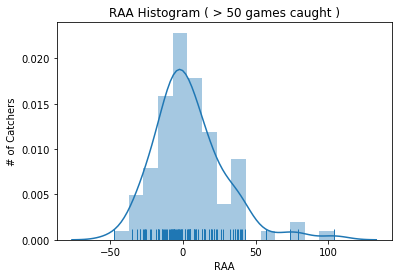

In [41]:
frData = pd.Series([x for x in list(catcherFR['RAA'])])
graph = sns.distplot(frData, kde = True, rug = True)
graph.set_title('RAA Histogram ( > 50 games caught )')
graph.set_xlabel('RAA')
graph.set_ylabel('# of Catchers')
plt.show()

<p>The data is definitely clustered around 0 which is expected as an RAA = 0 is considered the 'average' mlb catcher. The tail on the right of the plot can be attributed to the outlier best framing catchers who have a high number of <em>totalGames</em> between 2015 and 2018. It's also worth noting that there really isn't much of a tail on the lower end of the plot. Most likely, no catcher producing negative run value is going to stay in the MLB or behind the plate for long enough to drive the RAA down that far (unless you're Salvy in which case you make up for it elsewhere). Let's see how many outlier catchers we have. 

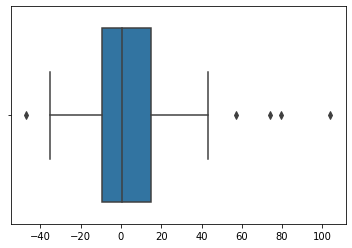

In [42]:
sns.boxplot(x=frData)

From the box plot we can see five outliers. These outliers are caused by catchers with above (or below) average <em>perGame</em> and a high <em>totalGames</em>. So while RAA is interesting to compare catchers based on added value, there is a lot of noise introduced by multiplying <em>totalGames</em> since so many factors can influence <em>totalGames</em>. For this reason, <em>perGame</em> is probably a more direct indicator of pure framing skill of each catcher.

Lets look at our top 5 catchers based on <em>perGame</em>

In [43]:
catcherFRpg.head(5)

,mlb_id,name,perGame,RAA
1,452095,Tyler Flowers,1.693622,79.288605
2,518735,Yasmani Grandal,1.563085,103.945129
3,425772,Jeff Mathis,1.555466,39.720388
4,605131,Austin Barnes,1.537278,32.099910
5,457763,Buster Posey,1.331269,73.833497


First and foremost, shoutout to my boy TFlow for repping #LosBravos and being first in <em>perGame</em> (a pitcher's best friend). 

Secondly, it's interesting to see two catchers with significantly higher <em>perGame</em> than Buster Posey but only have half Posey's <em>RAA</em>. To me, Posey's slightly lower <em>perGame</em> with such a high <em>RAA</em> is more impressive than Austin Barnes' or Jeff Mathis' <em>perGame</em> with low <em>RAA</em> simply because he's had to be consistently good over a long period of time to end up that high on the leaderboard. Mathias' and Barnes' haven't shown if they're capable of continuing their great frames over a longer period of time with more games. It's also important to note that Posey's <em>perGame</em> has significantly less fluctuation for each additional call than Mathias' and Barnes', that is to say, one bad streak of frames would drop Mathias' and Barnes' <em>perGame</em> much lower than that same bad streak would drop Posey.

I would argue that right now Mathias' and Barnes' frames are on-level (if not better) than Posey's, but we need to see if they can keep pace over a greater number of pitches before we can conclude they're a better overall framing catcher.

Let's see if our <em>perGame</em> data has any outliers.

count    100.000000
mean      -0.001602
std        0.852778
min       -3.488888
25%       -0.605843
50%        0.015208
75%        0.571415
max        1.693622
Name: perGame, dtype: float64

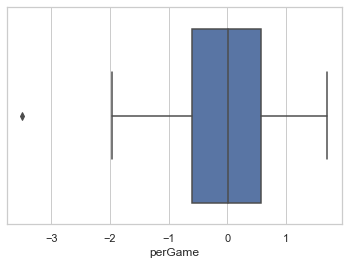

In [44]:
sns.set(style="whitegrid")
sns.boxplot(x=catcherFR["perGame"])
catcherFR['perGame'].describe()

<p>Looks like there is one low outlier. Who is it?</p>

In [45]:
catcherFRpg.loc[100,:]

mlb_id            541608
name       Ramon Cabrera
perGame         -3.48889
RAA             -25.9852
Name: 100, dtype: object

<p>Ramon Cabrera gets to take home the title of worst framing catcher since 2015. Ramon's atrocious framerate also raises the question, why was his framerate so bad? His outlier framerate implies that he was behind the plate for some reason other than catching. A quick google for his hitting stats shows:</p>

![ramon](ramon.png)

<p>Ramon got a late call up in 2015, hit .370 in 13 games and earned himself a spot as the backup catcher in 2016 for the Reds. He caught backup most of the year in 2016 (He played 15 games in the minors), swung a weak bat, and hasn't been in the majors since. Most likely, he was never on the field to be a defensive beast of a catcher and when the bat wasn't as hot as the Reds had hoped, they released him. Ramon also barely made the cut for > 50 games caught, so if we had more data on Ramon's framerates theres a good chance his framerate would increase.</p>

<p>Lets look at a histogram of our data without any outliers (sorry Ramon)</p>

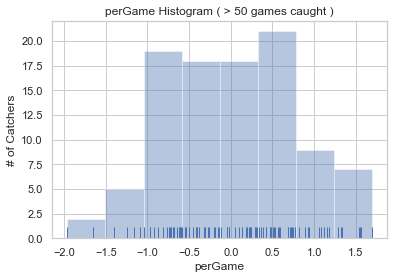

In [46]:
frData = pd.Series([x for x in list(catcherFR['perGame']) if x > -3])
graph = sns.distplot(frData, kde = False, rug = True)
graph.set_title('perGame Histogram ( > 50 games caught )')
graph.set_xlabel('perGame')
graph.set_ylabel('# of Catchers')
plt.show()

<p>Let's overlay a density plot to see an approximate distribution of the data</p>

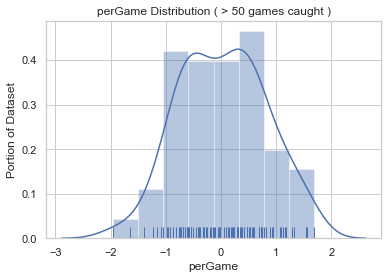

In [47]:
graph = sns.distplot(frData, kde = True, rug = True)
graph.set_title('perGame Distribution ( > 50 games caught )')
graph.set_xlabel('perGame')
graph.set_ylabel('Portion of Dataset')
plt.show()

Let's overlay a normal distribution on top of our data to compare distributions

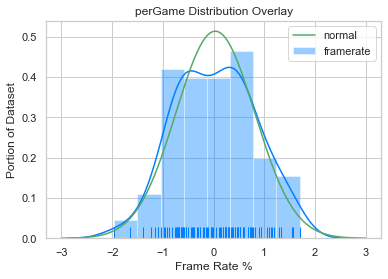

In [48]:
# Overlaying potential distributions
graph = sns.distplot(frData, color='#0080FF', kde = True, rug = True, label='framerate') # initializing graph with framerate data
# talk about choosing number of bins based on Freedman-Diaconis rule
x = np.linspace (-3, 3, 1000) # creating bins for overlayed distributions
fit_loc, fit_scale = st.norm.fit(frData) # fitting normal distribution
y1 = st.norm.pdf(x, scale=fit_scale, loc=fit_loc)
plt.plot(x, y1, "g-", label='normal') # overlaying normal distribution
graph.set_title('perGame Distribution Overlay')
graph.legend(loc='upper right')
graph.set_xlabel('Frame Rate %')
graph.set_ylabel('Portion of Dataset')
plt.show()

<p>The data looks almost normal, but there's a bimodal divot in the middle of our distribution. This divot is tricky because it may show that MLB catchers typically aren't just 'average', but rather that catchers tend to be either slightly above average or slightly below. Or the divot may just be caused by missing data (i.e. if we had more catchers in our dataset the divot wouldn't be here and this dataset just had an abnormally low concentration of 'average' catchers). If possible, a normal distribution would be easier to use for statistical conclusions on our dataset, even with the bimodal divot.

We can use a probability plot to see if our data matches expected values for a normal distribution. The closer the data is to a y=x line, the more normal our data is.</p>

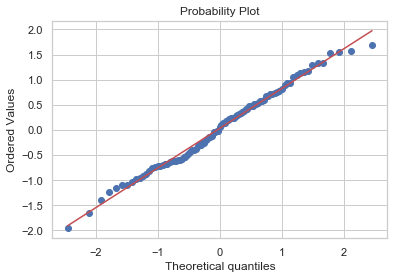

In [49]:
# probability dist plot to compare our sample to a distribution and see if similar
st.probplot(frData, dist="norm", plot=pylab)
pylab.show()

Our probability plot looks pretty normal, with most of the deviation away from the expected occuring at the tails of our distribution. Lets do hypothesis testing on our dataset to see if we can reject normality.

In [50]:
stat, p = st.normaltest(frData)
print('K2 Test Results:\n\tStatistics={}, p={}'.format(round(stat,3), round(p,3)))
alpha = 0.05
if p > alpha:
    print('\tSample looks Normal (fail to reject H0)')
else:
    print('\tSample does not look Normal (reject H0)')
stat, p = st.shapiro(frData)
print('Shapiro-Wilk Test Result:\n\tStatistics={}, p={}'.format(round(stat,3), round(p,3)))
if p > alpha:
    print('\tSample looks Normal (fail to reject H0)')
else:
    print('\tSample does not look Normal (reject H0)')

K2 Test Results:
	Statistics=1.521, p=0.467
	Sample looks Normal (fail to reject H0)
Shapiro-Wilk Test Result:
	Statistics=0.989, p=0.601
	Sample looks Normal (fail to reject H0)


In layman's terms, this dataset might be normal! For the sake of time and simplicity, I'm going to assume normality on our dataset. In the long run, we would want to perform regression on our dataset and account for any noise in our data (umpire call rates, pitch type rates, etc...) to find the best distribution for this data and use that to come to statistical conclusions. Unfortunately, that data just isn't available right now, so we'll just assume normality for the time being.

Let's use statistics to find a rough benchmark for the top 5% and 1% of catchers (in terms of framing) based on perGame.

In [51]:
t95 = st.norm.ppf(.95, loc=fit_loc, scale=fit_scale)
t99 = st.norm.ppf(.99, loc=fit_loc, scale=fit_scale)
print('\ntop 5%: perGame > {}'.format(round(t95,4)))
print('top 1%: perGame > {}'.format(round(t99,4)))


top 5%: perGame > 1.3111
top 1%: perGame > 1.8403


If we turn the stats back into english, we're saying that we're 99% sure that if we took every catcher in recent MLB history (lets say 2008, for the introduction of Statcast) and calculated their <em>perGame</em> over all their years of catching, there wouldn't be a catcher with a greater than 1.8403 <em>perGame</em>. Why is this important? Well if we did calculate it for every catcher since 2008 (or for every catcher going forward) and we saw a <em>perGame</em> above 1.84, we would need to have that catcher on SportsScience in a heartbeat. That catcher is doing something with his frames to seperate him from every other MLB catcher, he's a level above the rest.

It's also important to recognize that my value of 1.84 is based on multiple seasons worth of data and is an attempt at getting as close as possible to career perGame for each catcher (the more pitches caught, the less the perGame moves on each extra pitch, the closer to career totals). There ARE catchers with a <em>perGame</em> > 1.84 on the season, but those same catchers in this dataset are well below 1.84. In fact, 1.84 is .15 above our best catcher, TFlow, and the next best catcher behind TFlow is still .13 behind. 1.84 seems to be a legendary mark to pass in terms of career <em>perGame</em>.

To wrap up our statistical analysis, we can use Bayesian confidence intervals to come to a conlcusion about the true mean of <em>perGame</em> for every catcher since Statcast was introduced in '08.

In [52]:
a95 = st.bayes_mvs(frData, alpha = .95)
a99 = st.bayes_mvs(frData, alpha = .99)
print("\n95% certain: average perGame since '08 lies between {} and {}".format(round(a95[0][1][0],4),round(a95[0][1][1],4)))
print("99% certain: average perGame since '08 lies between {} and {}".format(round(a99[0][1][0],4),round(a99[0][1][1],4)))


95% certain: average perGame since '08 lies between -0.1221 and 0.1893
99% certain: average perGame since '08 lies between -0.1725 and 0.2397


These confidence intervals pass the common sense test ('average' should be 0) and show confidence that our data is at least a good general indicator of trends in catcher framing skills, the framing skills relationship with <em>perGame</em>, and how that correlates to <em>RAA</em> for a catcher.

### extraRate by Pitch Type

<p>First, lets import our ready made df</p>

In [53]:
pitchFR = pd.read_csv('pitchFR.csv', index_col=0)
pitchFR

,tBall,wStrike,tStrike,wBall,sRate,bRate,totalCalled,leagueSR,leagueBR,srDiff,brDiff,extraStr,extraBall,extraDiff,extraRate
2-seam,118920,11521,58608,8772,0.096880,0.149672,177528.0,0.077529,0.156586,0.019351,-0.006913,2301.211369,-405.175076,2706.386445,0.015245
4-seam,353283,33583,183481,27936,0.095060,0.152256,536764.0,0.077529,0.156586,0.017530,-0.004330,6193.203608,-794.501980,6987.705588,0.013018
changeup,101096,5820,29019,4845,0.057569,0.166960,130115.0,0.077529,0.156586,-0.019960,0.010374,-2017.905747,301.039388,-2318.945135,-0.017822
curveball,80507,5781,44636,5996,0.071807,0.134331,125143.0,0.077529,0.156586,-0.005722,-0.022255,-460.654249,-993.359587,532.705338,0.004257
cutter,51060,4293,21829,3364,0.084078,0.154107,72889.0,0.077529,0.156586,0.006548,-0.002479,334.352106,-54.109383,388.461490,0.005329
knuckle-curve,23656,1729,14401,1947,0.073089,0.135199,38057.0,0.077529,0.156586,-0.004440,-0.021387,-105.033971,-307.990757,202.956785,0.005333
knuckleball,3850,296,1831,374,0.076883,0.204260,5681.0,0.077529,0.156586,-0.000646,0.047674,-2.487943,87.291572,-89.779515,-0.015803
sinker,84967,8596,47599,6769,0.101169,0.142209,132566.0,0.077529,0.156586,0.023639,-0.014377,2008.564912,-684.323035,2692.887947,0.020314
slider,144508,10238,67284,9617,0.070847,0.142931,211792.0,0.077529,0.156586,-0.006682,-0.013654,-965.609279,-918.712664,-46.896616,-0.000221
split-fast,14193,680,3784,696,0.047911,0.183932,17977.0,0.077529,0.156586,-0.029618,0.027347,-420.373865,103.479687,-523.853552,-0.029140


Now let's view a barplot of <em>extraRate</em> by pitch type.

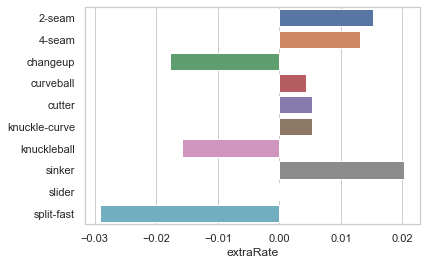

In [54]:
sns.barplot(x=pitchFR.extraRate, y=pitchFR.index, orient='h')

This bar graph plots net call rates by pitch type above the average net call rate for all pitches. This graph does <em>not</em> show which pitch is truly the hardest to frame, but rather shows that certain pitches, and the situations that they're thrown in most, have varying call rates. This leads to the question, what impacts these call rates most? 

Surely knuckleballs and change-ups (especially righty changeups breaking down and in on a catchers thumb) are hard for a catcher to really frame, but these pitches are typically thrown with the intent of fooling the batter into swinging (and missing of course). Is the intent of the pitch enough to drive the extra rate down well below average or are they actually that much more difficult to frame? Do lefty changeups have a higher call rate than righty changeups due to the change in direction of break?

Unsurprisingly, 2-seam and 4-seam fastballs have an above average call rate. This could be attributed to how easy they are to frame (little movement) or maybe its due to pitchers hitting their spots more when they throw fastballs. Does umpire 2-strike bias drive off-speed call rates higher? Why are the sinker and split-fast, two extremely similar pitches, extreme opposites in term of extraRate? 

As of right now I've found no way to track umpire call rates behind the plate (Statcast no longer records who was the umpire calling pitches) and this missing data is very important for adjusting these pitch types just to framerate. If anyone knows where this data is available please contact me as I'd love to implement it and create more accurate models.


Let's multiply each pitches' <em>extraRate</em> times <em>totalCalled</em> to weight each pitches' call rate by how often the pitch is actually utilized.
<p>&nbsp;</p>
\begin{align*}
totalExtra = extraRate * totalCalled
\end{align*}
<p>&nbsp;</p>

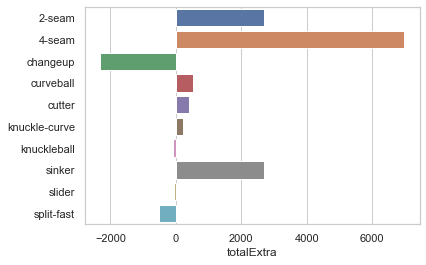

In [55]:
pitchFR['totalExtra'] = pitchFR.apply(lambda row: row.extraRate * row.totalCalled, axis=1)
sns.barplot(x=pitchFR.totalExtra, y=pitchFR.index, orient='h')

Just looking at this plot we can see that the 4-seam fastball, by pure volume, is a pitcher and catcher's best friend for getting added calls. It's also interesting to see the changeup have such a bad <em>extraRate</em> but still be thrown often enough to drive the <em>totalExtra</em> deep into the negatives. This just reinforces the point that pitchers (usually) aren't throwing changeups to catch batters looking. Also, split-fasts, despite being the on the extreme low end of <em>extraRate</em>, aren't thrown enough to have a huge impact on <em>totalExtra</em> like the fastball family does.

<a id='downloads'></a>
## Download any .csv's I made in the process of creating this notebook

<p>Download the .db file with every statcast pitch from 2008 through 2018 ( It's 2.8Gb !! ):</p>

[master_statcast.db](master_statcast.db)

<p>Download the fixed catcher xref .csv ( all credit to crunchtimebaseball for creating it ):</p>

[playerIDxref.csv](playerIDxref.csv)

<p>Download the complete catcher framerate .csv to crunch your own stats:</p>

[catcherFR.csv](catcherFR.csv)

[catcherFRpg.csv]('catcherFRpg.csv')

<p>Download the complete pitch type framerate .csv:
    
[pitchFR.csv](pitchFR.csv)

To go back to the top of this notebook, [CLICK HERE](#top)